By Luis Serrano (Oct 2019)

# Import Libraries

In [1]:
import multiprocessing
import os
import time
import numpy as np
import pandas as pd
from math import sqrt
from pandas import Series, DataFrame
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib import colors
import seaborn as sns
#from scipy import stats
from scipy.stats import kurtosis, kurtosistest
from scipy.stats import skew, skewtest
%matplotlib inline

#estimators
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
#from sklearn import tree


#model metrics
from sklearn import model_selection
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler,StandardScaler,RobustScaler
from sklearn.feature_selection import RFE,RFECV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score

# Set default matplot figure size
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

#https://stackoverflow.com/questions/52746279/how-to-get-absolutely-reproducible-results-with-scikit-learn
np.random.seed(4219)

# Data Structure

In [2]:
#data
rawData = pd.read_csv('default of credit card clients.csv', header=1)
rawData = rawData.rename(columns = {"default payment next month": "IN_DEFAULT","PAY_0": "PAY_1"})
rawData = rawData.drop(columns=['ID'])
rawData.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,IN_DEFAULT
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [3]:
rawData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
LIMIT_BAL     30000 non-null int64
SEX           30000 non-null int64
EDUCATION     30000 non-null int64
MARRIAGE      30000 non-null int64
AGE           30000 non-null int64
PAY_1         30000 non-null int64
PAY_2         30000 non-null int64
PAY_3         30000 non-null int64
PAY_4         30000 non-null int64
PAY_5         30000 non-null int64
PAY_6         30000 non-null int64
BILL_AMT1     30000 non-null int64
BILL_AMT2     30000 non-null int64
BILL_AMT3     30000 non-null int64
BILL_AMT4     30000 non-null int64
BILL_AMT5     30000 non-null int64
BILL_AMT6     30000 non-null int64
PAY_AMT1      30000 non-null int64
PAY_AMT2      30000 non-null int64
PAY_AMT3      30000 non-null int64
PAY_AMT4      30000 non-null int64
PAY_AMT5      30000 non-null int64
PAY_AMT6      30000 non-null int64
IN_DEFAULT    30000 non-null int64
dtypes: int64(24)
memory usage: 5.5 MB


In [4]:
rawData.columns

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_1', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'IN_DEFAULT'],
      dtype='object')

# Selecting Data

In [5]:
#features
features = rawData.iloc[:,0:23]
print('Summary of feature sample')
features.head()

Summary of feature sample


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000,2,2,1,24,2,2,-1,-1,-2,...,689,0,0,0,0,689,0,0,0,0
1,120000,2,2,2,26,-1,2,0,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
2,90000,2,2,2,34,0,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


In [6]:
#dependent variable
depVar = rawData['IN_DEFAULT']

In [7]:
#Training Set (Feature Space: X Training)
#Ref. https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
X_train = features.sample(frac=0.75,random_state=200)
X_train.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
17269,130000,2,2,1,34,0,0,0,0,0,...,104705,105478,107725,109994,3700,5300,4000,4000,4000,6100
22363,290000,2,1,2,27,-1,-1,0,0,0,...,1401,1503,834,931,569,1000,1000,200,265,500
23879,360000,1,1,2,27,-2,-2,-2,-2,-2,...,5939,1390,-5,-5,898,5970,1396,0,0,0
9073,110000,2,1,2,35,-1,2,-1,0,0,...,1166,790,806,1729,0,1166,0,446,1729,0
25082,260000,1,3,1,48,0,0,0,0,0,...,160654,155059,141570,134143,8000,6000,7100,5300,5000,5000


In [8]:
#Dependent Variable Training Set (y Training)
y_train = depVar[X_train.index]
y_train_count = len(y_train.index)
print('The number of observations in the Y training set are:',str(y_train_count))
y_train.head()

The number of observations in the Y training set are: 22500


17269    0
22363    0
23879    0
9073     0
25082    0
Name: IN_DEFAULT, dtype: int64

In [9]:
#Testing Set (X Testing)
X_test = features.drop(X_train.index)
X_test_count = len(X_test.index)
print('The number of observations in the feature testing set is:',str(X_test_count))
X_test.head()

The number of observations in the feature testing set is: 7500


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
3,50000,2,2,1,37,0,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
4,50000,1,2,1,57,-1,0,-1,0,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
5,50000,1,1,2,37,0,0,0,0,0,...,57608,19394,19619,20024,2500,1815,657,1000,1000,800
15,50000,2,3,3,23,1,2,0,0,0,...,28116,28771,29531,30211,0,1500,1100,1200,1300,1100
17,320000,1,1,1,49,0,0,0,-1,-1,...,194663,70074,5856,195599,10358,10000,75940,20000,195599,50000


In [10]:
#Ground Truth (y_test) 
y_test = depVar.drop(X_train.index)
y_test_count = len(y_test.index)
print('The number of observations in the Y training set are:',str(y_test_count))
y_test.head()

The number of observations in the Y training set are: 7500


3     0
4     0
5     0
15    0
17    0
Name: IN_DEFAULT, dtype: int64

In [11]:
#X_train, X_test, y_train, y_test = train_test_split(X_train, y_train) # Random split already done
X_train.shape, X_test.shape

((22500, 23), (7500, 23))

# Pre processing

## Apply scalers

In [12]:
#https://scikit-learn.org/stable/modules/preprocessing.html#preprocessing
#https://scikit-learn.org/0.18/auto_examples/preprocessing/plot_robust_scaling.html

minmax_scaler = MinMaxScaler()
Xtr_m = minmax_scaler.fit_transform(X_train)
Xte_m = minmax_scaler.transform(X_test)

standard_scaler = StandardScaler()
Xtr_s = standard_scaler.fit_transform(X_train)
Xte_s = standard_scaler.transform(X_test)

robust_scaler = RobustScaler()
Xtr_r = robust_scaler.fit_transform(X_train)
Xte_r = robust_scaler.transform(X_test)

## Choose right n for PCA (MinMax Scaler)

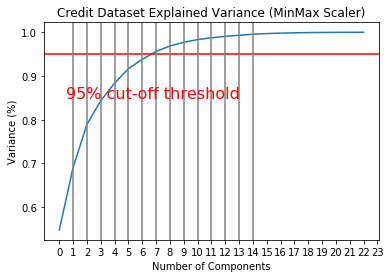

In [13]:
#https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
#https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
#Fitting the PCA algorithm with our Data
pca = PCA().fit(Xtr_m)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 24, step=1)) #change from 0-based array index to 1-based human-readabl
plt.ylabel('Variance (%)') #for each component
plt.title('Credit Dataset Explained Variance (MinMax Scaler)')
plt.axhline(y=0.95, color='r', linestyle='-')
for i in range(1,15):
    plt.axvline(x=i, color='gray')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()

  ## Choose right n for PCA (Standard Scaler)

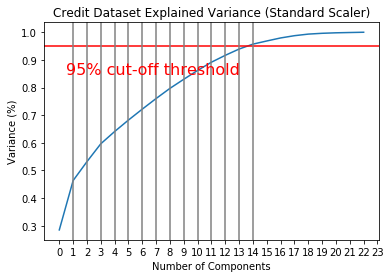

In [14]:
#https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
#https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
#Fitting the PCA algorithm with our Data
pca = PCA().fit(Xtr_s)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 24, step=1)) #change from 0-based array index to 1-based human-readabl
plt.ylabel('Variance (%)') #for each component
plt.title('Credit Dataset Explained Variance (Standard Scaler)')
plt.axhline(y=0.95, color='r', linestyle='-')
for i in range(1,15):
    plt.axvline(x=i, color='gray')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()

## Choose right n for PCA (Robust Scaler)

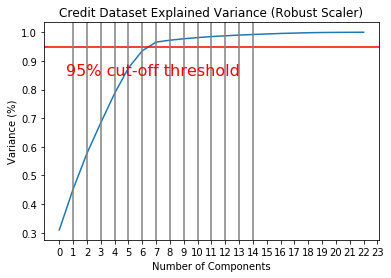

In [15]:
#https://towardsdatascience.com/an-approach-to-choosing-the-number-of-components-in-a-principal-component-analysis-pca-3b9f3d6e73fe
#https://www.mikulskibartosz.name/pca-how-to-choose-the-number-of-components/
#Fitting the PCA algorithm with our Data
pca = PCA().fit(Xtr_r)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.xticks(np.arange(0, 24, step=1)) #change from 0-based array index to 1-based human-readabl
plt.ylabel('Variance (%)') #for each component
plt.title('Credit Dataset Explained Variance (Robust Scaler)')
plt.axhline(y=0.95, color='r', linestyle='-')
for i in range(1,15):
    plt.axvline(x=i, color='gray')
plt.text(0.5, 0.85, '95% cut-off threshold', color = 'red', fontsize=16)
plt.show()

## Apply PCA

In [16]:
#https://stackabuse.com/implementing-pca-in-python-with-scikit-learn/

pca = PCA(n_components = 7)

Xtr_m = pca.fit_transform(Xtr_m)
Xte_m = pca.transform(Xte_m)

#Xtr_s = pca.fit_transform(Xtr_s)
#Xte_s = pca.transform(Xte_s)

#Xtr_r = pca.fit_transform(Xtr_r)
#Xte_r = pca.transform(Xte_r)

# Modeling (Classification)

## Compare models (MinMax Scaler)

*** KNN: mean accuracy=0.788089, mean SD=0.006278
     -- Using MinMaxScaler Scaler -- ...
        - Accuracy score   = 0.792
        - F1 score         = 0.413
              precision    recall  f1-score   support

           0       0.92      0.84      0.87      6453
           1       0.34      0.52      0.41      1047

    accuracy                           0.79      7500
   macro avg       0.63      0.68      0.64      7500
weighted avg       0.84      0.79      0.81      7500

   >>>> Elapsed time 5.445 


*** CART: mean accuracy=0.718489, mean SD=0.009462
     -- Using MinMaxScaler Scaler -- ...
        - Accuracy score   = 0.725
        - F1 score         = 0.390
              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5723
           1       0.41      0.37      0.39      1777

    accuracy                           0.72      7500
   macro avg       0.61      0.60      0.61      7500
weighted avg       0.72      0.72      0.72     

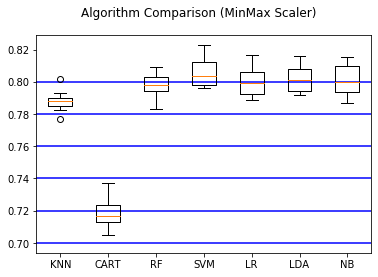

In [17]:
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('KNN' , KNeighborsClassifier(5
                                            ,weights = 'uniform'
                                            ,n_jobs = multiprocessing.cpu_count() - 1
    )))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF'  , RandomForestClassifier(n_estimators = 100
                                              ,n_jobs = multiprocessing.cpu_count() - 1)))
models.append(('SVM' , SVC(C=1.0
                           ,gamma='scale'
)))
models.append(('LR'  , LogisticRegression(penalty = 'l2'
                                          ,solver = 'lbfgs')))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('NB'  , GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, Xtr_m, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "*** %s: mean accuracy=%f, mean SD=%f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    model.fit(Xtr_m, y_train)
    #acc_m = model.score(Xte_m, y_test)
    print("     -- Using MinMaxScaler Scaler -- ...")
    #print("        - Testset accuracy = %.3f" % acc_m)
    predictions_m = model.predict(Xte_m)
    print("        - Accuracy score   = %.3f" % accuracy_score(predictions_m, y_test))
    print("        - F1 score         = %.3f" % f1_score(y_test,predictions_m))
    #https://muthu.co/understanding-the-classification-report-in-sklearn/
    #Precision – What percent of your predictions were correct?
    #Recall – What percent of the positive cases did you catch? 
    #F1 score – What percent of positive predictions were correct?
    print(classification_report(predictions_m, y_test))
    
    print("   >>>> Elapsed time %.3f \n\n" % (time.time() - start))

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (MinMax Scaler)')
ax = fig.add_subplot(111)
for i in range(70,82,2):
    plt.axhline(y=i/100, color='b', linestyle='-')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Compare models (Standard Scaler)

*** KNN: mean accuracy=0.789511, mean SD=0.006834
     -- Using Standard Scaler -- ...
        - Accuracy score   = 0.794
        - F1 score         = 0.426
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      6420
           1       0.36      0.53      0.43      1080

    accuracy                           0.79      7500
   macro avg       0.63      0.68      0.65      7500
weighted avg       0.83      0.79      0.81      7500

   >>>> Elapsed time 7.613 


*** CART: mean accuracy=0.724933, mean SD=0.008972
     -- Using Standard Scaler -- ...
        - Accuracy score   = 0.734
        - F1 score         = 0.403
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5770
           1       0.42      0.39      0.40      1730

    accuracy                           0.73      7500
   macro avg       0.62      0.61      0.62      7500
weighted avg       0.73      0.73      0.73      7500

 

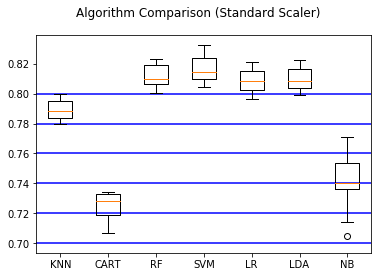

In [18]:
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('KNN' , KNeighborsClassifier(5
                                            ,weights = 'uniform'
                                            ,n_jobs = multiprocessing.cpu_count() - 1
    )))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF'  , RandomForestClassifier(n_estimators = 100
                                              ,n_jobs = multiprocessing.cpu_count() - 1)))
models.append(('SVM' , SVC(C=1.0
                           ,gamma='scale'
)))
models.append(('LR'  , LogisticRegression(penalty = 'l2'
                                          ,solver = 'lbfgs')))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('NB'  , GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, Xtr_s, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "*** %s: mean accuracy=%f, mean SD=%f" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    model.fit(Xtr_s, y_train)
    #acc_s = model.score(Xte_s, y_test)
    print("     -- Using Standard Scaler -- ...")
    #print("        - Testset accuracy = %.3f" % acc_s)
    predictions_s = model.predict(Xte_s)
    print("        - Accuracy score   = %.3f" % accuracy_score(predictions_s, y_test))
    print("        - F1 score         = %.3f" % f1_score(y_test,predictions_s))
    #https://muthu.co/understanding-the-classification-report-in-sklearn/
    #Precision – What percent of your predictions were correct?
    #Recall – What percent of the positive cases did you catch? 
    #F1 score – What percent of positive predictions were correct?
    print(classification_report(predictions_s, y_test))
    
    print("   >>>> Elapsed time %.3f \n\n" % (time.time() - start))

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Standard Scaler)')
ax = fig.add_subplot(111)
for i in range(70,82,2):
    plt.axhline(y=i/100, color='b', linestyle='-')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Compare models (Robust Scaler)

*** KNN: mean accuracy=0.790667, mean SD=0.007238
     -- Using Robust Scaler -- ...
        - Accuracy score   = 0.795
        - F1 score         = 0.422
              precision    recall  f1-score   support

           0       0.92      0.84      0.88      6446
           1       0.35      0.53      0.42      1054

    accuracy                           0.79      7500
   macro avg       0.63      0.69      0.65      7500
weighted avg       0.84      0.79      0.81      7500

   >>>> Elapsed time 4.931 


*** CART: mean accuracy=0.725556, mean SD=0.008440
     -- Using Robust Scaler -- ...
        - Accuracy score   = 0.736
        - F1 score         = 0.407
              precision    recall  f1-score   support

           0       0.82      0.84      0.83      5769
           1       0.42      0.39      0.41      1731

    accuracy                           0.74      7500
   macro avg       0.62      0.62      0.62      7500
weighted avg       0.73      0.74      0.73      7500

   >>

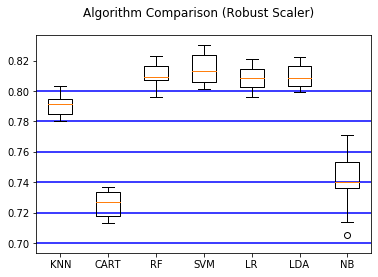

In [19]:
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/
# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
models.append(('KNN' , KNeighborsClassifier(5
                                            ,weights = 'uniform'
                                            ,n_jobs = multiprocessing.cpu_count() - 1
    )))
models.append(('CART', DecisionTreeClassifier()))
models.append(('RF'  , RandomForestClassifier(n_estimators = 100
                                              ,n_jobs = multiprocessing.cpu_count() - 1)))
models.append(('SVM' , SVC(C=1.0
                           ,gamma='scale'
)))
models.append(('LR'  , LogisticRegression(penalty = 'l2'
                                          ,solver = 'lbfgs')))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('NB'  , GaussianNB()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    start = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, Xtr_r, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "*** %s: mean accuracy=%f, mean SD=%f" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
    model.fit(Xtr_r, y_train)
    #acc_r = model.score(Xte_r, y_test)
    print("     -- Using Robust Scaler -- ...")
    #print("        - Testset accuracy = %.3f" % acc_r)
    predictions_r = model.predict(Xte_r)
    print("        - Accuracy score   = %.3f" % accuracy_score(predictions_r, y_test))
    print("        - F1 score         = %.3f" % f1_score(y_test,predictions_r))
    #https://muthu.co/understanding-the-classification-report-in-sklearn/
    #Precision – What percent of your predictions were correct?
    #Recall – What percent of the positive cases did you catch? 
    #F1 score – What percent of positive predictions were correct?    
    print(classification_report(predictions_r, y_test))
    
    print("   >>>> Elapsed time %.3f \n\n" % (time.time() - start))

# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison (Robust Scaler)')
ax = fig.add_subplot(111)
for i in range(70,82,2):
    plt.axhline(y=i/100, color='b', linestyle='-')
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

# Making Predictions and Evaluating the Results

In [20]:
#Make Predictions
selected_model = RandomForestClassifier(n_estimators = 100
                                       ,n_jobs = multiprocessing.cpu_count() - 1)
#selected_model = SVC(C=1.0
#                     ,gamma='scale'
#                    )
#selected_model = LogisticRegression(penalty = 'l2'
#                                    ,solver = 'lbfgs')

#selected_model = RFECV(estimator=selected_model
#                        ,cv=4
#                        ,scoring='accuracy'
#                        ,n_jobs = multiprocessing.cpu_count() - 1
#                        )
selected_model.fit(Xtr_s, y_train)
print("Testset accuracy using standard scaler = %.3f" % selected_model.score(Xte_s, y_test))
predictions = selected_model.predict(Xte_s)
#predRsquared = r2_score(y_test,predictions)
#rmse = sqrt(mean_squared_error(y_test, predictions))
#print('R Squared: %.3f' % predRsquared)
#print('RMSE: %.3f' % rmse)

Testset accuracy using standard scaler = 0.823


In [21]:
print(accuracy_score(predictions, y_test))

0.8233333333333334


In [22]:
print(classification_report(predictions, y_test))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      6523
           1       0.39      0.64      0.49       977

    accuracy                           0.82      7500
   macro avg       0.67      0.75      0.69      7500
weighted avg       0.87      0.82      0.84      7500



In [23]:
#https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428
#https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
#The F1 score can be interpreted as a weighted average of the precision and recall, 
#where an F1 score reaches its best value at 1 and worst score at 0. 
#The relative contribution of precision and recall to the F1 score are equal
#

predF1 = f1_score(y_test,predictions)
print('F1 score: %.3f' % predF1)

F1 score: 0.487


In [24]:
print(confusion_matrix(predictions, y_test))

[[5545  978]
 [ 347  630]]
